In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score

In [2]:
X_train, X_test, y_train, y_test = pd.read_csv('X_train.csv').iloc[: , 1:], \
                                   pd.read_csv('X_test.csv').iloc[: , 1:],\
                                   pd.read_csv('y_train.csv').iloc[: , 1:], \
                                   pd.read_csv('y_test.csv').iloc[: , 1:]

In [3]:
L = 10

In [4]:
def CreateRainfullDataSet_RNN(X, y, L):
    input_size = X.shape[1]
    X_RNN = torch.empty((1, L, input_size), dtype=torch.float64)
    y_RNN = torch.empty((1, L), dtype=torch.long)
    for j in range(16, 65):
        location_labels = np.where(X.iloc[: ,j] == 1)[0]
        training_index = []
        for i in location_labels[(L - 1):len(location_labels)]:
            training_index += np.arange(i- L + 1, i + 1).tolist()
            
        
        X_RNN  = torch.cat((X_RNN, torch.tensor(X.iloc[training_index, :].values).view(-1, L, input_size)), 0)
        y_RNN = torch.cat((y_RNN, torch.tensor(y.iloc[training_index].values).view(-1, L)), 0)
            
    return X_RNN[1:, :].float(), y_RNN[1:]

In [10]:
X_train_RNN, y_train_RNN = CreateRainfullDataSet_RNN(X_train, y_train, L)
X_test_RNN, y_test_RNN = CreateRainfullDataSet_RNN(X_test, y_test, L)

In [5]:
class RNN(torch.nn.Module):

    def __init__(self, rnn_option, input_size, hidden_size, n_layers, drop_p, seed=0):
        
        super().__init__()
        
        torch.manual_seed(seed)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.drop_p = drop_p
        
        self.rnn_option = rnn_option
        self.rnn = {
             'RNN': nn.RNN(input_size, hidden_size, n_layers, batch_first=True, dropout=drop_p),
             'GRU': nn.GRU(input_size, hidden_size, n_layers, batch_first=True, dropout=drop_p),
             'LSTM': nn.LSTM(input_size, hidden_size, n_layers, batch_first=True, dropout=drop_p)
        }[rnn_option]
        
        self.fc = nn.Linear(hidden_size, 2)
        self.activation = nn.ReLU()
        #self.activation = nn.Sigmoid()


    def forward(self, x):

        output = self.rnn(x)
        output = self.activation(output[0])
        output = self.fc(output)
        output = self.activation(output)
        output = nn.Softmax(dim=-1)(output)
        return output

In [6]:
def idx_to_onehot(x, device, k=2):
    """ Converts the integers to one-hot vectors """
    ones = torch.sparse.torch.eye(k).to(device)
    shape = x.shape
    res = ones.index_select(0, x.view(-1).type(torch.int64))
    return res.view(*shape, res.shape[-1])

In [7]:
def train_RNN_one_epoch(model, X_train, y_train, batch_size, criterion, optimizer, device):
  
    correct = 0
    loss_train = 0
    
    N = X_train.size()[0]
    batch_num = int(N / batch_size) - 1
    
   
    
    for batch_index in range(batch_num):
        
        #print(f'Batch: {batch_index}/{batch_num}')
        
        data, target = X_train[(batch_index * batch_size):(batch_size * (batch_index + 1)), :].to(device), \
                       y_train[(batch_index * batch_size):(batch_size * (batch_index + 1)),:].to(device)
        
      
        optimizer.zero_grad()
        
        output = model.forward(data)
        
        #loss = criterion(output[:, -1, :], target[:, -1])
        loss = criterion(output.view(-1, 2), target.view(-1))
        #loss = criterion(output, idx_to_onehot(target))
        loss.backward()
        optimizer.step()

        loss_train += loss / batch_size

        pred = torch.argmax(output, dim=-1)[:, -1]

        correct += (pred == target[:, -1]).int().sum().item()
        
    return correct, loss_train

In [8]:
def training_epochs(model, n_epochs, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN, batch_size, criterion, lr, device):
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    training_accuracy_list = []
    test_auc_list = []
    test_accuracy_list = []
    fp_list = []
    fn_list = []
    
    model.to(device)
    
    for epoch in range(n_epochs):

        print(f'{model.rnn_option}, n_layers={model.n_layers}, Start epoch: {epoch + 1}/{n_epochs}')
        correct, loss = train_RNN_one_epoch(model, X_train_RNN, y_train_RNN, batch_size, criterion, optimizer, device)
        train_accuracy = float(correct) / (X_train_RNN.size()[0])
        training_accuracy_list.append(train_accuracy)
    

        output_test = model.forward(X_test_RNN.to(device))[:, -1]
        pred_test = torch.argmax(output_test, dim=-1)
        target_test = y_test_RNN.to(device)[:, -1] 
        test_size = X_test_RNN.size()[0] 

        test_auc = roc_auc_score(idx_to_onehot(target_test, device).cpu().detach().numpy(), output_test.cpu().detach().numpy())
        test_auc_list.append(test_auc)
    
        test_accuracy = sum(pred_test == target_test).int().sum().item() / test_size
        test_accuracy_list.append(test_accuracy)
    
        false_positive = sum((pred_test==1) & (target_test==0)).int().sum().item() / test_size
        fp_list.append(false_positive)
    
        false_negative = sum((pred_test==0) & (target_test==1)).int().sum().item() / test_size
        fn_list.append(false_negative)

        print(f'Train epoch: {epoch + 1}/{n_epochs}, loss: {loss:.3f}, train accuracy: {100*train_accuracy:.1f}%,\n \
        test accuracy: {100*test_accuracy:.1f}%, false_positive: {100*false_positive:.1f}%, false_negative: {100*false_negative:.1f}%.')
    
    return {'train_acc':training_accuracy_list, 
            'test_auc':test_auc_list, 
            'test_acc':test_accuracy_list, 
            'test_fp':fp_list, 
            'test_fn':fn_list}
    

In [29]:
model_RNN = RNN(rnn_option='RNN',input_size=X_train_RNN.size(-1), hidden_size=64, n_layers=1, drop_p=0, seed=1234)
model_RNN_stacked = RNN(rnn_option='RNN',input_size=X_train_RNN.size(-1), hidden_size=64, n_layers=2, drop_p=0.1, seed=100)
#model_RNN_3 = RNN(rnn_option='RNN',input_size=X_train_RNN.size(-1), hidden_size=64, n_layers=3, drop_p=0, seed=1234)
model_GRU = RNN(rnn_option='GRU',input_size=X_train_RNN.size(-1), hidden_size=64, n_layers=1, drop_p=0, seed=1000)
model_GRU_stacked = RNN(rnn_option='GRU',input_size=X_train_RNN.size(-1), hidden_size=64, n_layers=2, drop_p=0, seed=1000)
model_LSTM = RNN(rnn_option='LSTM',input_size=X_train_RNN.size(-1), hidden_size=64, n_layers=1, drop_p=0, seed=1000)
model_LSTM_stacked = RNN(rnn_option='LSTM',input_size=X_train_RNN.size(-1), hidden_size=64, n_layers=2, drop_p=0, seed=1000)

criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cpu")

n_epochs = 20
batch_size = 64
lr = 3e-5

results_RNN = training_epochs(model_RNN, n_epochs, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN, batch_size, criterion, lr, device)
results_RNN_stacked = training_epochs(model_RNN_stacked, n_epochs, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN, batch_size, criterion, lr, device)
#results_RNN_3 = training_epochs(model_RNN_3, n_epochs, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN, batch_size, criterion, lr, device)
results_GRU = training_epochs(model_GRU, n_epochs, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN, batch_size, criterion, 1e-4, device)
results_GRU_stacked = training_epochs(model_GRU_stacked, n_epochs, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN, batch_size, criterion, lr, device)
results_LSTM = training_epochs(model_LSTM, n_epochs, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN, batch_size, criterion, lr, device)
results_LSTM_stacked = training_epochs(model_LSTM_stacked, n_epochs, X_train_RNN, y_train_RNN, X_test_RNN, y_test_RNN, batch_size, criterion, lr, device)

RNN, n_layers=2, Start epoch: 1/20
Train epoch: 1/20, loss: 19.641, train accuracy: 77.8%,
         test accuracy: 78.8%, false_positive: 0.0%, false_negative: 21.2%.
RNN, n_layers=2, Start epoch: 2/20
Train epoch: 2/20, loss: 18.935, train accuracy: 78.0%,
         test accuracy: 78.8%, false_positive: 0.0%, false_negative: 21.2%.
RNN, n_layers=2, Start epoch: 3/20
Train epoch: 3/20, loss: 18.086, train accuracy: 79.6%,
         test accuracy: 81.2%, false_positive: 1.2%, false_negative: 17.7%.
RNN, n_layers=2, Start epoch: 4/20
Train epoch: 4/20, loss: 16.972, train accuracy: 83.3%,
         test accuracy: 83.2%, false_positive: 1.9%, false_negative: 14.9%.
RNN, n_layers=2, Start epoch: 5/20
Train epoch: 5/20, loss: 16.566, train accuracy: 84.2%,
         test accuracy: 83.8%, false_positive: 2.1%, false_negative: 14.2%.
RNN, n_layers=2, Start epoch: 6/20
Train epoch: 6/20, loss: 16.415, train accuracy: 84.4%,
         test accuracy: 83.9%, false_positive: 2.0%, false_negative: 14.2%

Train epoch: 10/20, loss: 16.236, train accuracy: 84.8%,
         test accuracy: 84.2%, false_positive: 2.1%, false_negative: 13.7%.
GRU, n_layers=2, Start epoch: 11/20
Train epoch: 11/20, loss: 16.224, train accuracy: 84.8%,
         test accuracy: 84.2%, false_positive: 2.1%, false_negative: 13.7%.
GRU, n_layers=2, Start epoch: 12/20
Train epoch: 12/20, loss: 16.214, train accuracy: 84.8%,
         test accuracy: 84.3%, false_positive: 2.1%, false_negative: 13.6%.
GRU, n_layers=2, Start epoch: 13/20
Train epoch: 13/20, loss: 16.205, train accuracy: 84.9%,
         test accuracy: 84.3%, false_positive: 2.1%, false_negative: 13.6%.
GRU, n_layers=2, Start epoch: 14/20
Train epoch: 14/20, loss: 16.196, train accuracy: 84.9%,
         test accuracy: 84.3%, false_positive: 2.1%, false_negative: 13.6%.
GRU, n_layers=2, Start epoch: 15/20
Train epoch: 15/20, loss: 16.189, train accuracy: 84.9%,
         test accuracy: 84.3%, false_positive: 2.1%, false_negative: 13.6%.
GRU, n_layers=2, Start

Train epoch: 19/20, loss: 16.123, train accuracy: 85.0%,
         test accuracy: 84.6%, false_positive: 2.1%, false_negative: 13.3%.
LSTM, n_layers=2, Start epoch: 20/20
Train epoch: 20/20, loss: 16.114, train accuracy: 85.0%,
         test accuracy: 84.6%, false_positive: 2.1%, false_negative: 13.3%.


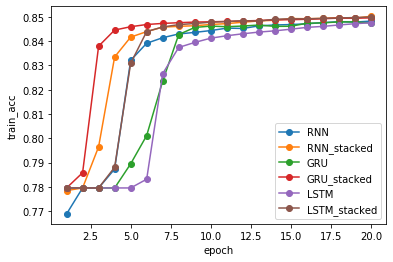

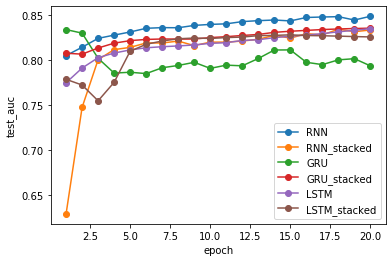

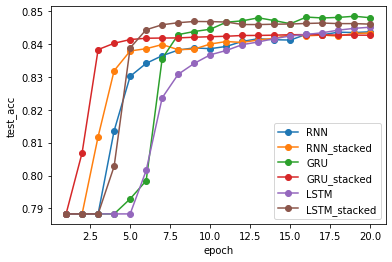

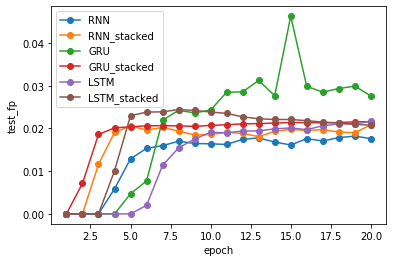

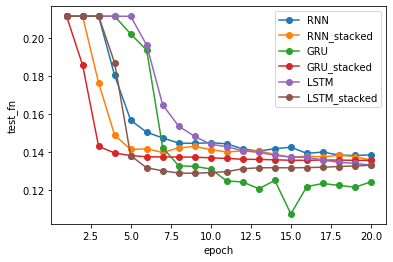

In [33]:
for key in results_RNN:
    plt.plot(np.arange(1, n_epochs+1), results_RNN[key], linestyle='-', marker='o', label='RNN')
    plt.plot(np.arange(1, n_epochs+1), results_RNN_stacked[key],  linestyle='-', marker='o', label='RNN_stacked') 
    plt.plot(np.arange(1, n_epochs+1), results_GRU[key],  linestyle='-', marker='o', label='GRU') 
    plt.plot(np.arange(1, n_epochs+1), results_GRU_stacked[key], linestyle='-', marker='o',  label='GRU_stacked') 
    plt.plot(np.arange(1, n_epochs+1), results_LSTM[key], linestyle='-', marker='o', label='LSTM') 
    plt.plot(np.arange(1, n_epochs+1), results_LSTM_stacked[key],  linestyle='-', marker='o', label='LSTM_stacked') 
    plt.xlabel('epoch')
    plt.ylabel(key)
    plt.legend()
    plt.savefig(f'RNN, {key}, L={L}.jpeg')
    plt.show()